# Download the Data

In [1]:
%%capture
!pip3 install tqdm
!pip install timm
!pip install -U albumentations
!pip install --ignore-installed Pillow==9.0.0
!pip install utils

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import cv2
import albumentations as A
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from torch import nn 
import timm
import utils

In [3]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
class Config():
  img_size = 255
  batch_size = 16
  model_name = 'efficientnet_b0'
  lr = 0.001
  epoches = 10
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extracting Annotations from XML Format

In [5]:
"""Create a list that contains all paths to images meta data in XML file"""
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]


'data/annotations/xmls/miniature_pinscher_106.xml'

In [6]:
classes = ['cat', 'dog'] # rewrite
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

## Extract Annotations

In [7]:
def extract_annotation(xml_file_path):

    img_dir = 'data/images'
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['image_name'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['object'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['object'].append({
                     'class_id': class_id, 
                     'xmin': xmin,
                     'ymin': ymin,
                     'xmax': xmax,
                     'ymax': ymax
                 }) 
    if os.path.exists(img_dir + '/' + annotation['image_name']):
      annotation['image_path'] = img_dir + '/' + annotation['image_name']
    else:
      raise OSError
    
    return annotation

In [8]:
extracted_files = []
for path in xml_files:
  extracted_files.append(extract_annotation(path))
print(len(extracted_files))

3686


In [9]:
extracted_files[1]


{'image_name': 'British_Shorthair_174.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 375, 'depth': 3}],
 'object': [{'class_id': 0,
   'xmin': 134,
   'ymin': 79,
   'xmax': 297,
   'ymax': 234}],
 'image_path': 'data/images/British_Shorthair_174.jpg'}

In [10]:
"""Delete images which are too small"""
extracted_files = [img for img in extracted_files if img['image_size'][0]['width'] >= 225]
extracted_files = [img for img in extracted_files if img['image_size'][0]['height'] >= 225]

In [11]:
a, b = int(len(extracted_files)*0.85), int(len(extracted_files)*0.7)
train_files, valid_files, test_files = extracted_files[: b], extracted_files[b:a], extracted_files[a:]
print(f'Length of training set is {len(train_files)}')
print(f'Length of validating set is {len(valid_files)}')
print(f'Length of test set is {len(test_files)}')
assert len(train_files) + len(valid_files) + len(test_files) == len(extracted_files)

Length of training set is 2443
Length of validating set is 523
Length of test set is 524


# Visualize Data

In [12]:
ran_img = extracted_files[223]
ran_img 

{'image_name': 'american_bulldog_192.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 406, 'depth': 3}],
 'object': [{'class_id': 1,
   'xmin': 67,
   'ymin': 125,
   'xmax': 237,
   'ymax': 358}],
 'image_path': 'data/images/american_bulldog_192.jpg'}

In [13]:
extracted_files[223]['object'][0]['xmin']

67

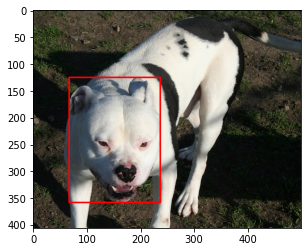

In [14]:
img = cv2.imread(ran_img['image_path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (ran_img['object'][0]['xmin'], ran_img['object'][0]['ymin'])
pt2 = (ran_img['object'][0]['xmax'], ran_img['object'][0]['ymax'])
bnd_box = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(img)

# Augmentations

In [15]:
train_aug = A.Compose([
  A.Resize(Config.img_size, Config.img_size),
  A.HorizontalFlip(p = 0.5),
  A.VerticalFlip(p = 0.5),
  A.Rotate()],
  bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_labels'])
)
valid_aug = A.Compose([
  A.Resize(Config.img_size, Config.img_size)],
  bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_labels']) # bbox take list(list)
)
test_aug = A.Compose([
  A.Resize(Config.img_size, Config.img_size)],
  bbox_params=A.BboxParams(format='pascal_voc', label_fields= ['class_labels']) # bbox take list(list)
)

# Create Custom Dataset

In [16]:
class CatDogDataset(Dataset):
  def __init__(self, extracted_files: list, aug=None):
    self.extracted_files = extracted_files
    self.aug = aug

  def __len__(self):
    return len(self.extracted_files)

  def __getitem__(self, index):

    img_path = self.extracted_files[index]['image_path']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    xmin = self.extracted_files[index]['object'][0]['xmin']
    ymin = self.extracted_files[index]['object'][0]['ymin']
    xmax = self.extracted_files[index]['object'][0]['xmax']
    ymax = self.extracted_files[index]['object'][0]['ymax']

    bbox = [[xmin, ymin, xmax, ymax]] 

    if self.aug:
      data = self.aug(image=img, bboxes=bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255 # was: (h, w, channel) after permute (channel, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [17]:
trainset, validset, testset = CatDogDataset(train_files, train_aug), CatDogDataset(valid_files, valid_aug), CatDogDataset(test_files, test_aug)

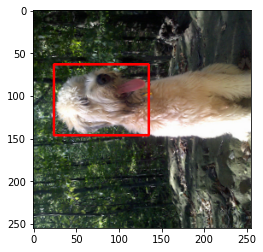

In [18]:
img, bbox = trainset[570]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Download Data to Dataloaders

In [19]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Config.batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=Config.batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Config.batch_size, shuffle=True)

In [20]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 153
Total no. batches in validloader : 33


In [22]:
for i, batch in enumerate(trainloader):
  images, bboxes = batch
  print("Shape of one batch images : {}".format(images.shape))
  print("Shape of one batch bboxes : {}".format(bboxes.shape))
  if i > 1:
    break

Shape of one batch images : torch.Size([16, 3, 255, 255])
Shape of one batch bboxes : torch.Size([16, 4])
Shape of one batch images : torch.Size([16, 3, 255, 255])
Shape of one batch bboxes : torch.Size([16, 4])
Shape of one batch images : torch.Size([16, 3, 255, 255])
Shape of one batch bboxes : torch.Size([16, 4])


# Create a Model

In [23]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.backbone = timm.create_model(Config.model_name, pretrained=True, num_classes=4)

  def forward(self, images, gt_boxes=None):
    bboxes = self.backbone(images)

    if gt_boxes != None:
      loss = nn.MSELoss()(bboxes, gt_boxes)
      return gt_boxes, loss
    else:
      return bboxes

In [ ]:
model = Model()
model.to('cuda')

In [25]:
ran_img = torch.rand(1, 3, 255, 255).to('cuda')
model(ran_img).shape

torch.Size([1, 4])

# Create Useful Functions

In [26]:
def train_fn(model, trainloader, optimizer):
    
    train_loss = 0.0
    model.train() #dropout ON
    
    for data in trainloader:
        
        images, gt_bboxes = data
        images, gt_bboxes = images.to('cuda'), gt_bboxes.to('cuda')
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss/len(trainloader)


def validation_fn(model, validloader):
    train_loss = 0.0
    model.eval() #dropout OFF
    
    with torch.no_grad():
      for data in validloader:
          images, gt_bboxes = data
          images, gt_bboxes = images.to('cuda'), gt_bboxes.to('cuda')
          
          bboxes, loss = model(images, gt_bboxes)
          
          train_loss += loss.item()
            
    return train_loss/len(trainloader)

# Create a Training Loop

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)

In [28]:
best_loss = np.Inf
for i in tqdm(range(Config.epoches)):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = validation_fn(model, validloader)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_loss = valid_loss

  print(f'Epoch №: {i + 1} train loss: {train_loss} valid loss {valid_loss}')

 10%|█         | 1/10 [00:32<04:53, 32.65s/it]

Epoch №: 1 train loss: 5458.338425580193 valid loss 205.52809711531097


 20%|██        | 2/10 [01:05<04:22, 32.84s/it]

Epoch №: 2 train loss: 747.7997761645348 valid loss 76.68141114478017


 30%|███       | 3/10 [01:38<03:49, 32.85s/it]

Epoch №: 3 train loss: 464.0556409249898 valid loss 75.88363936679815


 40%|████      | 4/10 [02:10<03:15, 32.53s/it]

Epoch №: 4 train loss: 391.67418266745176 valid loss 61.370368309270326


 50%|█████     | 5/10 [02:42<02:42, 32.45s/it]

Epoch №: 5 train loss: 334.29774514989913 valid loss 54.98568810356988


 60%|██████    | 6/10 [03:15<02:09, 32.42s/it]

Epoch №: 6 train loss: 316.1175373551113 valid loss 68.91344028049045


 70%|███████   | 7/10 [03:48<01:38, 32.67s/it]

Epoch №: 7 train loss: 284.0393165638244 valid loss 48.706023272346044


 80%|████████  | 8/10 [04:21<01:05, 32.66s/it]

Epoch №: 8 train loss: 279.95250377779695 valid loss 53.91163470698338


 90%|█████████ | 9/10 [04:53<00:32, 32.76s/it]

Epoch №: 9 train loss: 267.13729150310843 valid loss 67.4206166984209


100%|██████████| 10/10 [05:26<00:00, 32.65s/it]

Epoch №: 10 train loss: 264.2330608492583 valid loss 41.07851898592282


# Check Model Performance

In [123]:
def find_iou(index):

  model.load_state_dict(torch.load('best_model.pt'))
  model.eval()

  with torch.no_grad():

    image, gt_box = testset[index]
    image = image.unsqueeze(0).to(Config.device) # image shoud be with batch size (bs, c, h, w),
    # It is used to add an extra dimension for batch as model takes (batch, channel, height, width)
    x_t_min, y_t_min, x_t_max, y_t_max = np.array(gt_box)
    model_bbox = model(image)
    x_m_min, y_m_min = model_bbox.data.cpu().numpy()[0][0], model_bbox.data.cpu().numpy()[0][1]
    x_m_max, y_m_max = model_bbox.data.cpu().numpy()[0][2], model_bbox.data.cpu().numpy()[0][3]

    # calculate coordinates of intersection
    x_inter_min = int(max(x_t_min, x_m_min))
    y_inter_min = int(max(y_t_min, y_m_min))
    x_inter_max = int(min(x_t_max, x_m_max))
    y_inter_max = int(min(y_t_max, y_m_max))

    #calculate width, heigh and area of intersection
    width_inter = abs(x_inter_max - x_inter_min)
    heigh_inter = abs(y_inter_max - y_inter_min)
    area_inter = width_inter*heigh_inter

    #calculate width, heigh and area of ground truth box
    width_gt = abs(x_t_max - x_t_min)
    heigh_gt = abs(y_t_max - y_t_min)
    area_gt = width_gt*heigh_gt

    #calculate width, heigh and area of model box
    width_m = abs(x_m_max - x_m_min)
    heigh_m = abs(y_m_max - y_m_min)
    area_m = width_m*heigh_m

    #calculate Union
    union = area_gt + area_m - area_inter

  return area_inter / union 


### Compute IOU

In [89]:
all_iou = []
for i in range(len(testset)):
  res = find_iou(i)
  all_iou.append(res)
all_iou = np.array(all_iou)

In [90]:
all_iou.mean()

0.70934314

### Visualize

120.87 1.36 199.92 102.0
119.39309 27.110062
193.75954 102.4492
120 27
193 102
IoU: 0.68


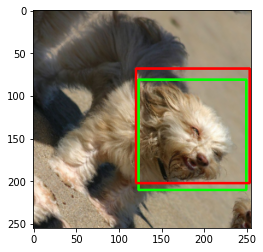

In [122]:
index = 7
img, bbox = trainset[index]
xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

model_image = img.unsqueeze(0).to(Config.device)
model_bbox = model(model_image)
x_m_min, y_m_min = model_bbox.data.cpu().numpy()[0][0], model_bbox.data.cpu().numpy()[0][1]
x_m_max, y_m_max = model_bbox.data.cpu().numpy()[0][2], model_bbox.data.cpu().numpy()[0][3]

pt1_m = (int(x_m_min), int(y_m_min))
pt2_m = (int(x_m_max), int(y_m_max))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (0,255,0), 2)
bnd_img_m = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1_m, pt2_m, (255,0,0), 2)
plt.imshow(bnd_img)
 
iou = find_iou(index)
print("IoU: {:.2f}".format(iou))
		